In [1]:
import os
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix,f1_score
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt,style

Using TensorFlow backend.


In [2]:
style.use('ggplot')
np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          recall,precision,f2,f1,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.text(0,2.3, f" Recall:{recall},\n Precision:{precision},\n F2 Score:{f2},\n F1 Score:{f1}", fontsize=12)
    plt.show()

In [3]:
seed(10)

In [4]:
training_data = pd.read_csv('/Users/abhijit/Desktop/Data_iot/features-cached/Google-Home.csv')
training_data = training_data.drop(['network_local','anonymous_source_destination','device','state'],axis = 1)
training_data.head()

,meanBytes,minBytes,maxBytes,medAbsDev,skewLength,kurtosisLength,q10,q20,q30,q40,...,spanOfGroup,meanTBP,varTBP,medianTBP,kurtosisTBP,skewTBP,network_to,network_from,network_both,network_to_external
0,98.59375,66,409,11.860818,3.581331,13.110559,66.0,66.0,66.0,69.2,...,32.709213,1.595629,15.750566,0.006768,9.684856,3.077266,0,0,0,32
1,89.75000,66,252,5.930409,2.785853,9.380262,66.0,66.0,66.0,66.0,...,32.715753,0.619863,2.471613,0.006857,13.862859,3.678952,0,0,0,32
2,85.31250,66,149,11.860818,1.077298,0.108313,66.0,66.0,66.0,66.0,...,32.715753,1.043425,6.108288,0.012848,3.420998,2.237208,0,0,0,32
3,91.65625,66,186,19.273829,1.683033,2.273708,66.0,66.0,68.4,74.0,...,31.285906,2.147835,31.927413,0.007013,4.738252,2.546162,0,0,0,32
4,103.62500,66,252,39.288959,1.963110,3.702616,66.0,66.0,75.5,82.0,...,32.709213,1.039979,12.995421,0.012772,17.459678,4.206468,0,0,0,32


In [5]:
testing_data = pd.read_csv('/Users/abhijit/Desktop/Data_iot/features-cached/new-google-home.csv')
testing_data = testing_data.drop(['network_local','anonymous_source_destination','device','state'],axis = 1)
testing_data.head()

,meanBytes,minBytes,maxBytes,medAbsDev,skewLength,kurtosisLength,q10,q20,q30,q40,...,spanOfGroup,meanTBP,varTBP,medianTBP,kurtosisTBP,skewTBP,network_to,network_from,network_both,network_to_external
0,290.487805,66,1580,47.443271,2.345118,4.147364,66.0,66.0,66.0,74.0,...,27.811600,0.379762,1.041280,0.001530,8.511178,3.090544,0,0,0,41
1,294.487805,66,1580,11.860818,2.138520,2.874584,66.0,66.0,66.0,66.0,...,33.308688,0.833055,3.280472,0.006748,2.288814,1.968455,0,0,0,41
2,313.414634,66,1580,103.782155,2.300855,4.019465,66.0,66.0,86.0,102.0,...,28.711271,1.004811,3.470445,0.007478,1.132001,1.625762,0,0,0,41
3,273.170732,66,1580,56.338884,2.404824,4.277922,66.0,66.0,74.0,96.0,...,32.382668,0.720146,2.854265,0.003375,3.485260,2.200012,0,0,0,41
4,221.536585,66,1580,35.582453,3.282328,10.459258,66.0,66.0,66.0,79.0,...,28.711271,0.710720,2.835952,0.007478,3.702637,2.269794,0,0,0,41


In [6]:
testing_data['anomaly'] = False

In [7]:
anomaly_data = pd.read_csv('/Users/abhijit/Desktop/GIT_Projects/intl-iot/model/features-testing1.1/us/yi-camera.csv')
anomaly_data = anomaly_data.drop(['network_local','anonymous_source_destination','device','state'],axis = 1)
anomaly_data.head()

,meanBytes,minBytes,maxBytes,medAbsDev,skewLength,kurtosisLength,q10,q20,q30,q40,...,spanOfGroup,meanTBP,varTBP,medianTBP,kurtosisTBP,skewTBP,network_to,network_from,network_both,network_to_external
0,169.031250,46,1214,29.652044,3.036190,8.953171,50.0,54.0,54.0,65.2,...,94.699169,0.256499,1.233653,0.011785,25.677235,5.212452,50,70,0,8
1,160.101562,46,1214,14.826022,3.273655,9.789039,50.0,54.0,54.0,62.0,...,94.699169,0.146500,0.382363,0.010183,77.798463,8.288856,56,69,0,3
2,159.250000,46,1214,23.721635,3.230347,10.081830,50.0,54.0,54.0,54.0,...,94.699045,0.111549,0.336569,0.008734,103.026808,9.924942,52,68,0,8
3,186.226562,46,1214,29.652044,2.870199,7.741643,50.0,54.0,62.0,66.0,...,94.699169,0.183938,0.460517,0.013273,73.163848,7.890162,60,63,0,5
4,178.250000,46,1214,17.791227,2.982131,8.014788,54.0,54.0,54.0,66.0,...,94.699045,0.081481,0.050542,0.008417,16.486251,4.049408,53,69,0,6


In [8]:
anomaly_data['anomaly']  = True

In [9]:
anomaly_frames = [testing_data,anomaly_data]
anomaly_data = pd.concat(anomaly_frames)

In [10]:
anomaly_data = anomaly_data.reset_index(drop=True)

In [11]:
results = anomaly_data['anomaly']
anomaly_data = anomaly_data.drop(['anomaly'],axis=1)

In [12]:
anomaly_data.shape

(14930, 25)

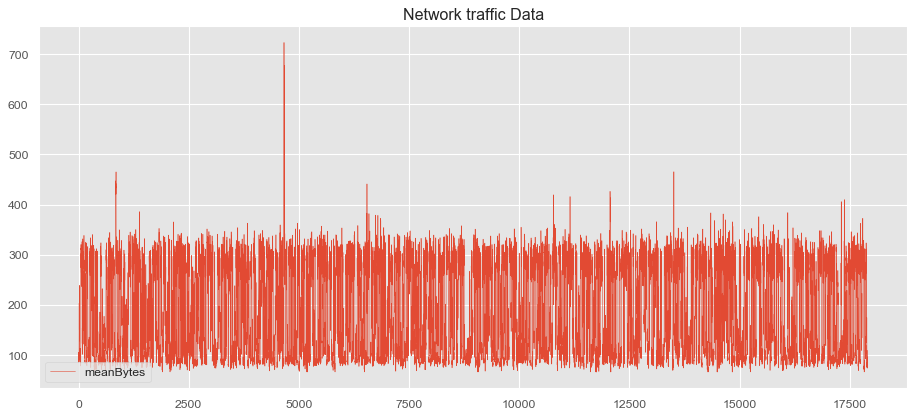

In [13]:
fig,ax = plt.subplots(figsize=(14,6),dpi = 80)
for i in (training_data.columns[0:1]):
    ax.plot(training_data[i],label=i,animated=True,linewidth=0.5)
plt.legend(loc = 'lower left')
ax.set_title('Network traffic Data')
plt.show()

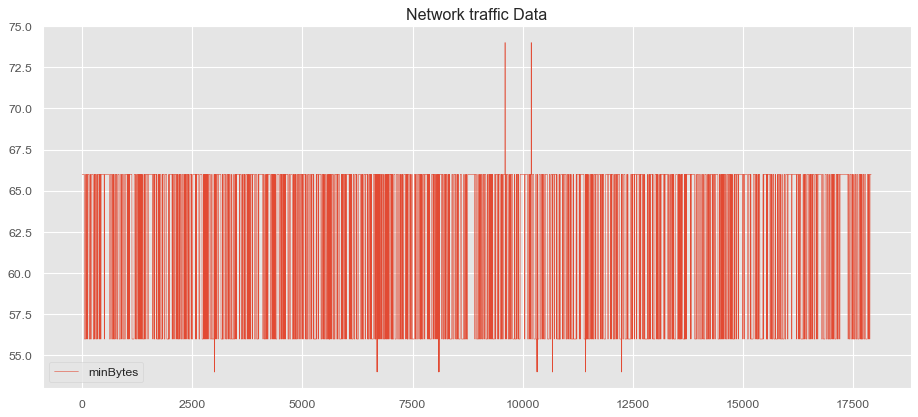

In [14]:
fig,ax = plt.subplots(figsize=(14,6),dpi = 80)
for i in (training_data.columns[1:2]):
    ax.plot(training_data[i],label=i,animated=True,linewidth=0.5)
plt.legend(loc = 'lower left')
ax.set_title('Network traffic Data')
plt.show()

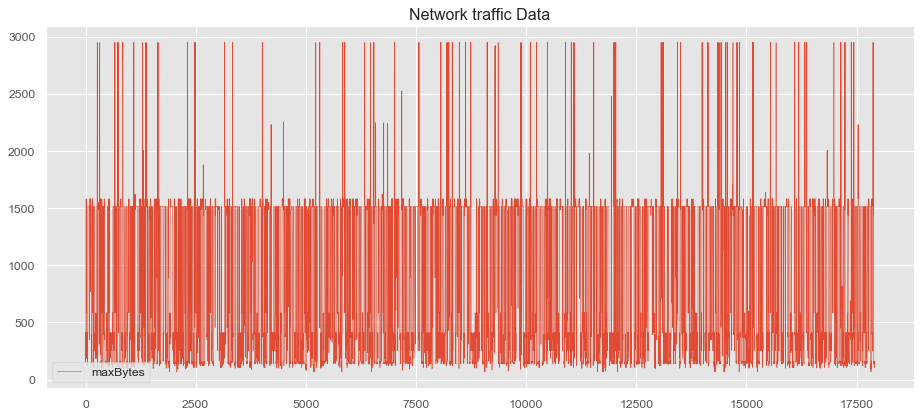

In [15]:
fig,ax = plt.subplots(figsize=(14,6),dpi = 80)
for i in (training_data.columns[2:3]):
    ax.plot(training_data[i],label=i,animated=True,linewidth=0.5)
plt.legend(loc = 'lower left')
ax.set_title('Network traffic Data')
plt.show()

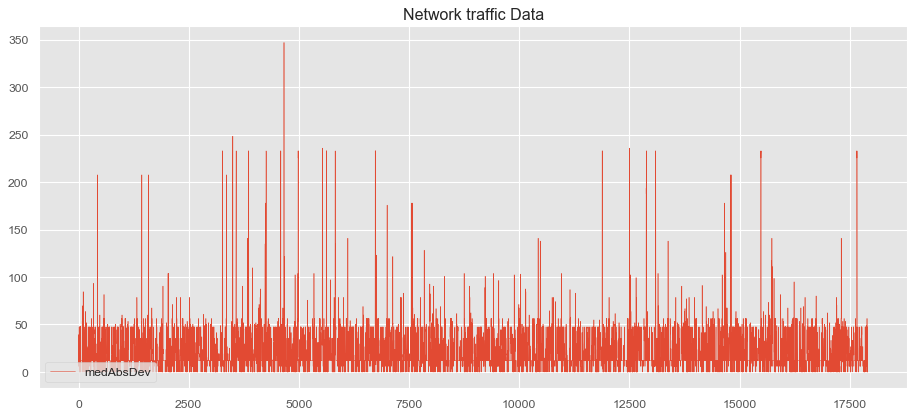

In [16]:
fig,ax = plt.subplots(figsize=(14,6),dpi = 80)
for i in (training_data.columns[3:4]):
    ax.plot(training_data[i],label=i,animated=True,linewidth=0.5)
plt.legend(loc = 'lower left')
ax.set_title('Network traffic Data')
plt.show()

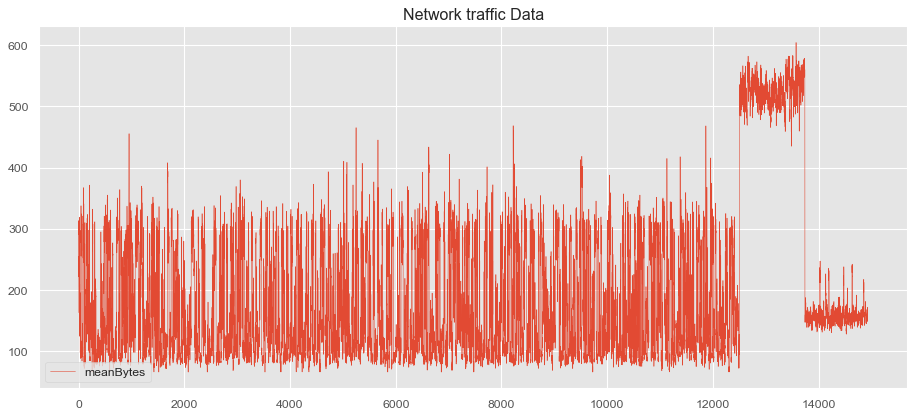

In [17]:
fig,ax = plt.subplots(figsize=(14,6),dpi = 80)
for i in (training_data.columns[0:1]):
    ax.plot(anomaly_data[i],label=i,animated=True,linewidth=0.5)
plt.legend(loc = 'lower left')
ax.set_title('Network traffic Data')
plt.show()

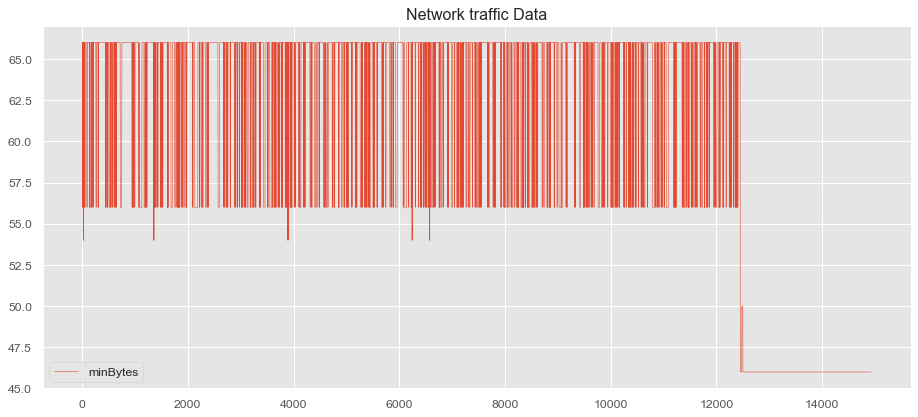

In [18]:
fig,ax = plt.subplots(figsize=(14,6),dpi = 80)
for i in (training_data.columns[1:2]):
    ax.plot(anomaly_data[i],label=i,animated=True,linewidth=0.5)
plt.legend(loc = 'lower left')
ax.set_title('Network traffic Data')
plt.show()

In [19]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(training_data)
X_test = scaler.fit_transform(anomaly_data)
scaler_filename = 'scaler_data'
joblib.dump(scaler,scaler_filename)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


['scaler_data']

In [20]:
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
print(f'Training data shape: {X_train.shape}')
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
print(f'Test data shape: {X_test.shape}')

Training data shape: (17910, 1, 25)
Test data shape: (14930, 1, 25)


In [21]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1],X.shape[2]))
    L1 = LSTM(16, activation='relu',return_sequences=True,
             kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu',return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu',return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu',return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs,outputs=output)
    return model    

In [22]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam',loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 25)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             2688      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 25)             425 

In [23]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train,X_train,epochs=nb_epochs,batch_size=batch_size,
                   validation_split=0.05).history

Train on 17014 samples, validate on 896 samples
Epoch 1/100
17014/17014 [==============================] - 8s 451us/step - loss: 0.0422 - val_loss: 0.0265
Epoch 2/100
17014/17014 [==============================] - 6s 351us/step - loss: 0.0255 - val_loss: 0.0246
Epoch 3/100
17014/17014 [==============================] - 6s 370us/step - loss: 0.0236 - val_loss: 0.0231
Epoch 4/100
17014/17014 [==============================] - 6s 356us/step - loss: 0.0225 - val_loss: 0.0225
Epoch 5/100
17014/17014 [==============================] - 6s 357us/step - loss: 0.0218 - val_loss: 0.0220
Epoch 6/100
17014/17014 [==============================] - 7s 389us/step - loss: 0.0216 - val_loss: 0.0218
Epoch 7/100
17014/17014 [==============================] - 6s 368us/step - loss: 0.0214 - val_loss: 0.0218
Epoch 8/100
17014/17014 [==============================] - 6s 357us/step - loss: 0.0213 - val_loss: 0.0217
Epoch 9/100
17014/17014 [==============================] - 6s 358us/step - loss: 0.0213 - val_lo

17014/17014 [==============================] - 7s 388us/step - loss: 0.0180 - val_loss: 0.0185
Epoch 77/100
17014/17014 [==============================] - 7s 411us/step - loss: 0.0180 - val_loss: 0.0186
Epoch 78/100
17014/17014 [==============================] - 7s 414us/step - loss: 0.0179 - val_loss: 0.0185
Epoch 79/100
17014/17014 [==============================] - 7s 413us/step - loss: 0.0178 - val_loss: 0.0183
Epoch 80/100
17014/17014 [==============================] - 7s 412us/step - loss: 0.0177 - val_loss: 0.0183
Epoch 81/100
17014/17014 [==============================] - 7s 416us/step - loss: 0.0177 - val_loss: 0.0185
Epoch 82/100
17014/17014 [==============================] - 7s 417us/step - loss: 0.0176 - val_loss: 0.0182
Epoch 83/100
17014/17014 [==============================] - 7s 405us/step - loss: 0.0176 - val_loss: 0.0182
Epoch 84/100
17014/17014 [==============================] - 7s 408us/step - loss: 0.0175 - val_loss: 0.0181
Epoch 85/100
17014/17014 [===============

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'Upper Right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


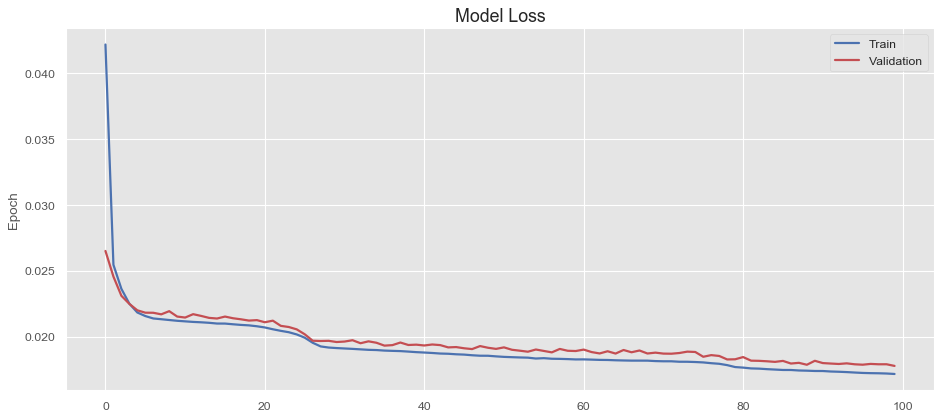

In [24]:
fig,ax = plt.subplots(figsize=(14,6),dpi=80)
ax.plot(history['loss'],'b',label='Train',linewidth=2)
ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
ax.set_title('Model Loss',fontsize=16)
ax.set_ylabel('Loss(mse)')
ax.set_ylabel('Epoch')
ax.legend(loc='Upper Right')
plt.show()

(0.0, 0.3)

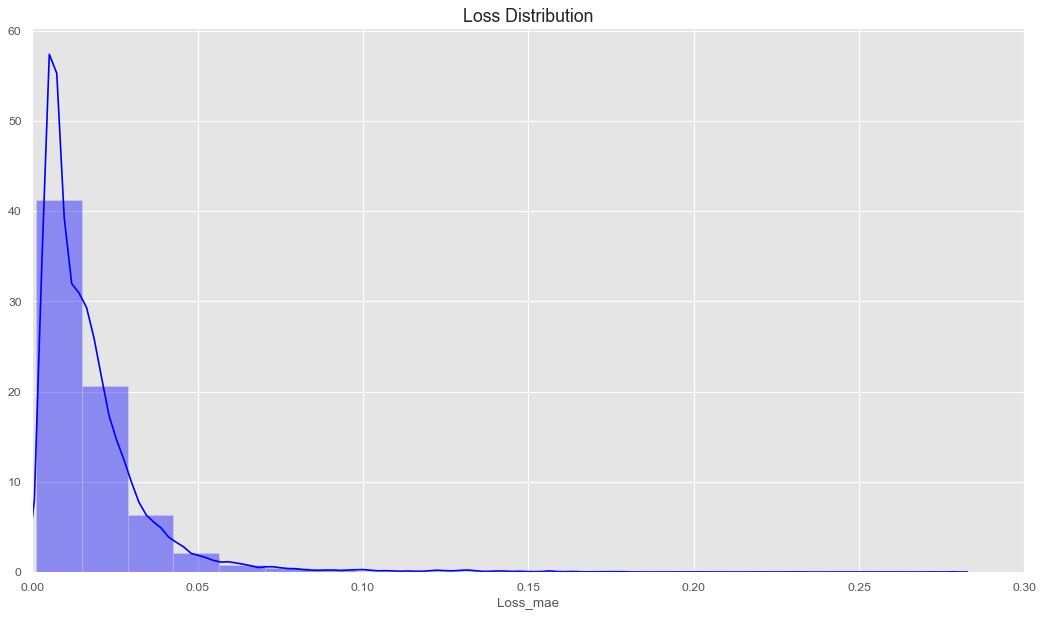

In [34]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=training_data.columns)
X_pred.index = training_data.index

scored = pd.DataFrame(index=training_data.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.3])

In [26]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=anomaly_data.columns)
X_pred.index = anomaly_data.index

scored = pd.DataFrame(index=anomaly_data.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.1
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored['actual'] = results
scored_test = scored
scored.head()

,Loss_mae,Threshold,Anomaly,actual
0,0.097218,0.1,False,False
1,0.122140,0.1,True,False
2,0.107869,0.1,True,False
3,0.086389,0.1,False,False
4,0.083690,0.1,False,False


In [27]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=training_data.columns)
X_pred_train.index = training_data.index

scored_train = pd.DataFrame(index=training_data.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.1
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored_train['actual'] = False
scored = pd.concat([scored_train, scored])
scored = scored.reset_index(drop=True)

In [28]:
scored_test.shape

(14930, 4)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'Upper Right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


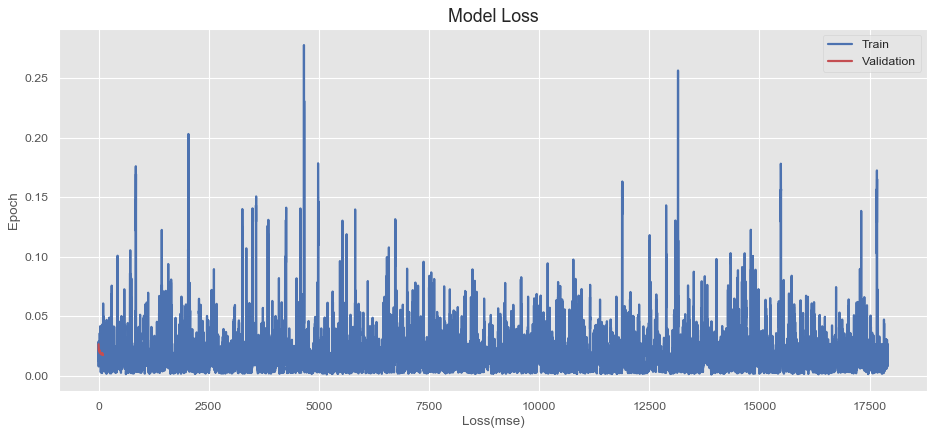

In [29]:
fig,ax = plt.subplots(figsize=(14,6),dpi=80)
ax.plot(scored_train['Loss_mae'],'b',label='Train',linewidth=2)
ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
ax.set_title('Model Loss',fontsize=16)
ax.set_xlabel('Loss(mse)')
ax.set_ylabel('Epoch')
ax.legend(loc='Upper Right')
plt.show()

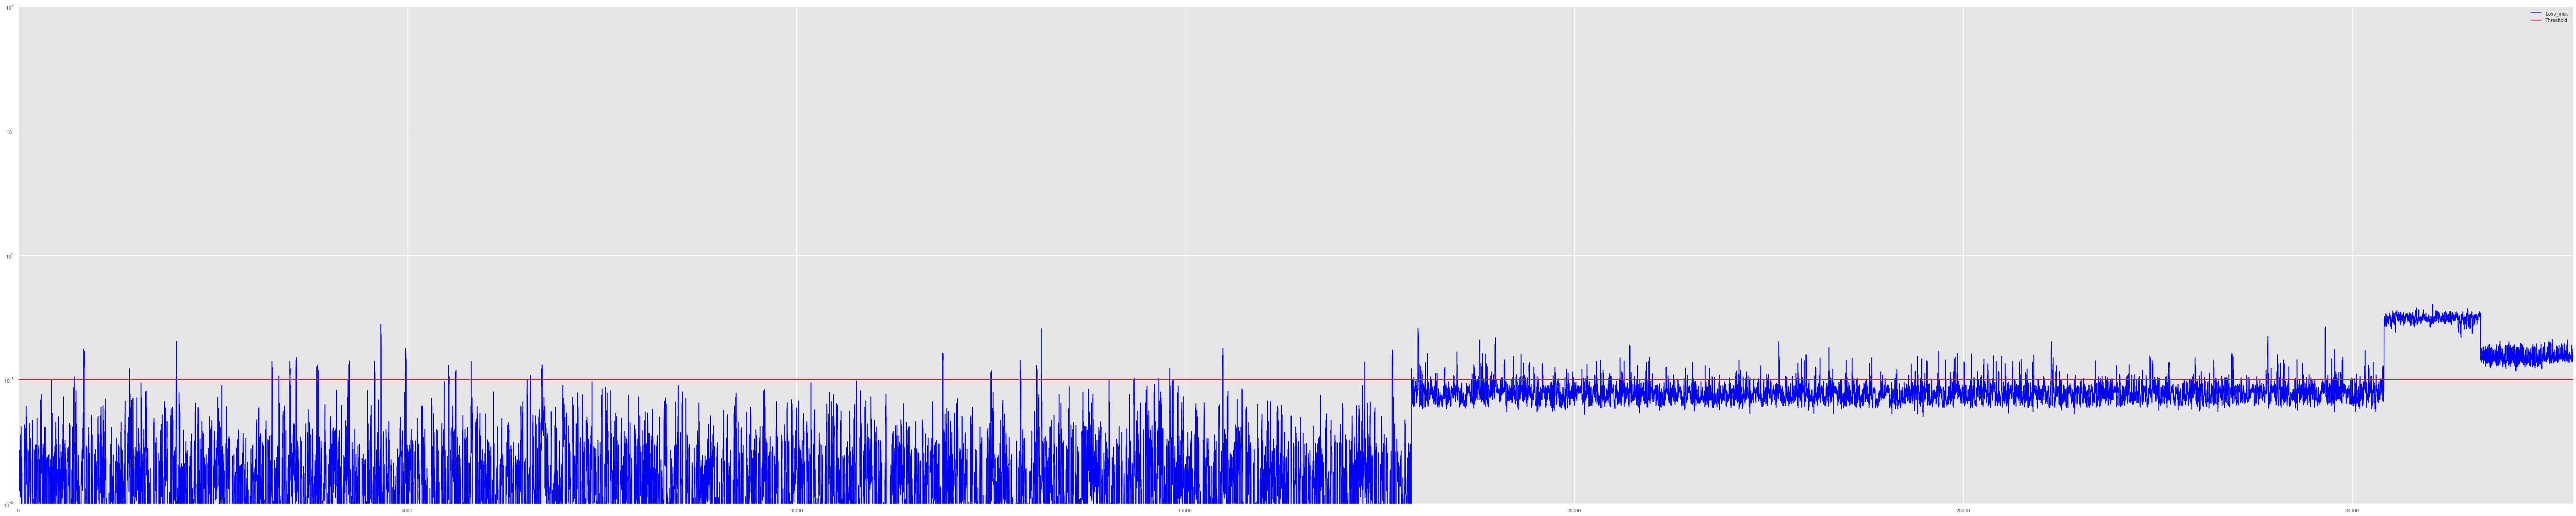

In [33]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(100,20), ylim=[1e-2,1e2], color=['blue','red'])

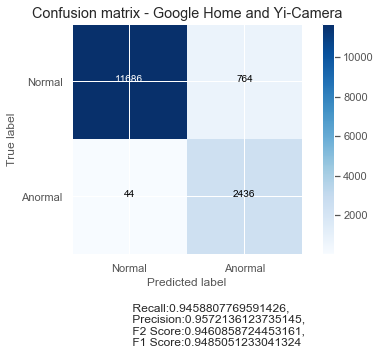

In [31]:
recall = recall_score(y_pred=scored_test['Anomaly'].values, y_true=scored_test['actual'].values,average='weighted')
precision = precision_score(y_pred=scored_test['Anomaly'].values, y_true=scored_test['actual'].values,average='weighted')
f2 = fbeta_score(y_pred=scored_test['Anomaly'].values, y_true=scored_test['actual'].values,average='weighted', beta=2)
f1 = f1_score(y_pred=scored_test['Anomaly'].values, y_true=scored_test['actual'].values,average='weighted')

cnf_matrix = confusion_matrix(scored_test['actual'].values,scored_test['Anomaly'].values)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'],
                      recall=recall,precision=precision,f2 = f2,f1=f1, title=f'Confusion matrix - Google Home and Yi-Camera')

In [35]:
model.save('lstm_anomaly_model.h5')